# FoodVision101 classification task using transfer learning with EfficientNetB0

In [3]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
tf.__version__

'2.12.0'

Some utility functions

In [3]:
import zipfile

# function to extract file
def extract_zip(zipped_file):
    zip_ref = zipfile.ZipFile(zipped_file)
    zip_ref.extractall()
    zip_ref.close()

## plot learning curves
def plot_learning_curves(history):
    loss= history.history['loss']
    val_loss = history.history['val_loss']

    acc= history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='training_loss')
    plt.plot(val_loss, label='validation_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs validation_loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc, label='training_acc')
    plt.plot(val_acc, label='validation_acc')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('train_accuracy vs validation_accuracy')
    plt.grid()
    plt.legend()

    plt.show()

# function to process image
def process_image(img, target_size=(224, 224)):
    x = load_img(img, target_size=target_size)
    x = img_to_array(x)
    return x

def predict_plot(model, img):
    pred_prob = model.predict(tf.expand_dims(img, 0))
    pred_class = tf.argmax(pred_prob[0])
    label = class_names[int(pred_class)]
    plt.imshow(img)
    plt.title(label)
    plt.axis(False)


### Data Download and Preparation

In [4]:
import tensorflow_datasets as tfds

In [5]:
## get all tfds
datasets_list = tfds.list_builders()

In [6]:
datasets_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence']

In [7]:
dataset = 'food101'
print(f"dataset in Tfds: {dataset in datasets_list}")

dataset in Tfds: True


In [8]:
## load the data

(train_data, test_data), ds_info = tfds.load(name=dataset,
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ7232W/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ7232W/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
class_names = ds_info.features['label'].names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

### Know the data

In [11]:
sample = train_data.take(1)
sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in sample:
    print(image.shape, image.dtype)
    print(label)
    print(class_names[label.numpy()])

(512, 512, 3) <dtype: 'uint8'>
tf.Tensor(56, shape=(), dtype=int64)
huevos_rancheros


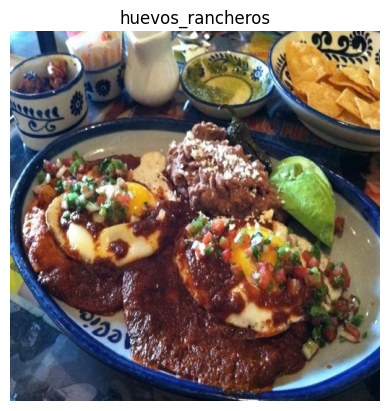

In [13]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [14]:
len(train_data), len(test_data)

(75750, 25250)

In [11]:
def preprocess_image(img, label, img_size=224):
    image = tf.image.resize(img, [img_size, img_size])
    return tf.cast(image, tf.float32), label

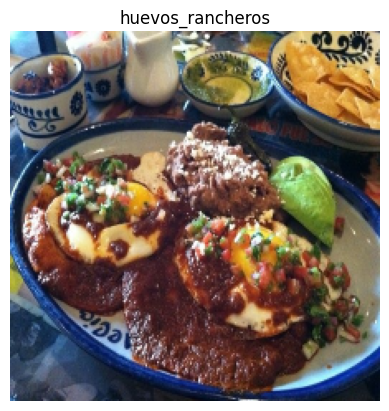

In [16]:
processed_image = preprocess_image(image, label)[0]
plt.imshow(processed_image/255.)
plt.title(class_names[label.numpy()])
plt.axis(False);

### Dataset Preparation
preprocess, shuffle, batch and prefetch data

In [12]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# prepare train data
train_dataset = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# prepare test data
test_dataset = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [28]:
# Since train dataset is being shuffled, we get a different set each time

count=0
for images, label in train_dataset.unbatch():
      print(label.numpy())
      count+=1

      if count==10:
        break


59
39
0
1
65
34
4
1
99
0


In [48]:
# While we haven't applied shuffle on test data, so it will be same always
count=0
for images, label in test_dataset.unbatch():
      print(label.numpy())
      count+=1

      if count==10:
        break

29
81
91
53
97
97
10
31
3
100


### Creating callbacks

In [31]:
import datetime
## Create ModelCheckpoint thet saves best weights

checkpoint_path = 'model_checkpoints/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              save_best_only=True,
                                              save_weights_only=True,
                                              verbose=0)


## Create tensorboard callback
log_dir = 'log_dir' + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)


### Using Mixed Precision

In [32]:
from tensorflow.keras import mixed_precision

# Set mixed prcision policy
mixed_precision.set_global_policy(policy="mixed_float16")

In [33]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Model architecture

Using pretrained model EfficientNetB0

In [34]:
def create_model():
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable=False

    inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name='gap2D')(x)
    x = tf.keras.layers.Dense(101)(x)
    outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [35]:
# Create model and check summary
model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 gap2D (GlobalAveragePoolin  (None, 1280)              0         
 g2D)                                                            
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [36]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

check the dtype policies for model layers

In [37]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
gap2D True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [38]:
for layer in model.layers[1].layers[:10]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">


### fitting the model

In [39]:
# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=len(train_dataset),
                    validation_data=test_dataset,
                    validation_steps=int(0.1 * len(test_dataset)),
                    callbacks=[tb_callback, cp_callback])

Epoch 1/5
2368/2368 [==============================] - 280s 109ms/step - loss: 1.7191 - accuracy: 0.5813 - val_loss: 1.1282 - val_accuracy: 0.7013
Epoch 2/5
2368/2368 [==============================] - 267s 110ms/step - loss: 1.1997 - accuracy: 0.6906 - val_loss: 1.0309 - val_accuracy: 0.7251
Epoch 3/5
2368/2368 [==============================] - 242s 100ms/step - loss: 1.0539 - accuracy: 0.7241 - val_loss: 0.9994 - val_accuracy: 0.7267
Epoch 4/5
2368/2368 [==============================] - 235s 97ms/step - loss: 0.9594 - accuracy: 0.7480 - val_loss: 0.9806 - val_accuracy: 0.7310
Epoch 5/5
2368/2368 [==============================] - 197s 82ms/step - loss: 0.8888 - accuracy: 0.7666 - val_loss: 0.9987 - val_accuracy: 0.7259


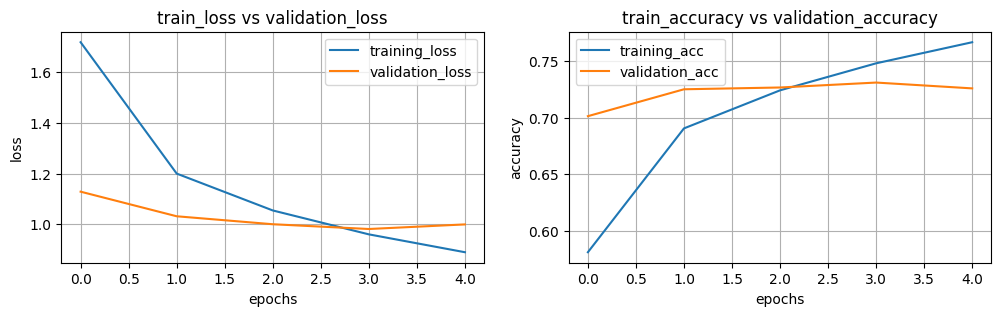

In [40]:
plot_learning_curves(history)

Model tending to overfit. We have got a good enough score.

Evaluating on test_dataset

In [41]:
result = model.evaluate(test_dataset)
result

790/790 [==============================] - 61s 77ms/step - loss: 0.9844 - accuracy: 0.7301


[0.9844241738319397, 0.7300990223884583]

### Save the model

(Note we also checkpointed best weights)

In [42]:
# model saved after 4 epochs run
model.save('food_vision_model_fe_ENetB0.keras')

In [ ]:
model.save('food_vision_model_fe_ENetB0.h5')

### loading saved model

In [44]:
loaded_model = tf.keras.models.load_model('food_vision_model_fe_ENetB0.keras')
loaded_model.evaluate(test_dataset)

790/790 [==============================] - 59s 69ms/step - loss: 0.9844 - accuracy: 0.7301


[0.9844241738319397, 0.7300990223884583]

### loading model with best saved weights

We will evaluate and compare with the model we have saved

In [46]:
# create model instance
model_wt = create_model()
model_wt.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

# evaluate befor loading weights - untrained model
model_wt.evaluate(test_dataset)

790/790 [==============================] - 61s 73ms/step - loss: 4.6967 - accuracy: 0.0124


[4.696683883666992, 0.012435643933713436]

In [47]:
# load weights and evaluate
model_wt.load_weights(checkpoint_path)
loaded_model_wt_results = model_wt.evaluate(test_dataset)
loaded_model_wt_results

790/790 [==============================] - 59s 74ms/step - loss: 0.9807 - accuracy: 0.7337


[0.9807263016700745, 0.7337425947189331]

In [49]:
model_wt.save('food_vision_model_best_weights_ENetB0.keras')

## Save EfficientNet0 5 epochs result to a DataFrame

In [51]:
import pandas as pd

In [59]:
values = {'model':'EfficientNetB0', 'loss':[round(loaded_model_wt_results[0], 3)], 'accuracy':[round(loaded_model_wt_results[1], 3)]}
model_performance = pd.DataFrame(values)
model_performance

model   loss  accuracy
0  EfficientNetB0  0.981     0.734

In [60]:
model_performance.to_csv('foodVision_model_perf.csv')

## Test on custom images

In [61]:
!wget 'https://github.com/JSini/foodVision101/raw/main/food_test_images.zip'

--2023-08-05 08:47:33--  https://github.com/JSini/foodVision101/raw/main/food_test_images.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JSini/foodVision101/main/food_test_images.zip [following]
--2023-08-05 08:47:33--  https://raw.githubusercontent.com/JSini/foodVision101/main/food_test_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420314 (410K) [application/zip]
Saving to: ‘food_test_images.zip’

food_test_images.zi 100%[===================>] 410.46K  --.-KB/s    in 0.04s   

2023-08-05 08:47:33 (9.44 MB/s) - ‘food_test_images.zip’ saved [420314/420314]



In [62]:
!unzip  '/content/food_test_images.zip'

Archive:  /content/food_test_images.zip
  inflating: food_test_images/burger.jpg  
  inflating: food_test_images/burger_2.jpg  
  inflating: food_test_images/free-stock-food-photography-websites.jpg  
  inflating: food_test_images/icecream.jfif  
  inflating: food_test_images/icecream2.jfif  
  inflating: food_test_images/pizza.jpg  
  inflating: food_test_images/pizza_2.jpg  


In [63]:
test_img_dir = 'food_test_images'
test_images = [os.path.join(test_img_dir, fn) for fn in os.listdir(test_img_dir)]
test_images

['food_test_images/pizza_2.jpg',
 'food_test_images/burger_2.jpg',
 'food_test_images/icecream2.jfif',
 'food_test_images/icecream.jfif',
 'food_test_images/pizza.jpg',
 'food_test_images/burger.jpg',
 'food_test_images/free-stock-food-photography-websites.jpg']

In [64]:
foodvision_model = tf.keras.models.load_model('/content/food_vision_model_fe_ENetB0.keras')

In [65]:
class_names = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']

In [66]:
len(class_names)

101

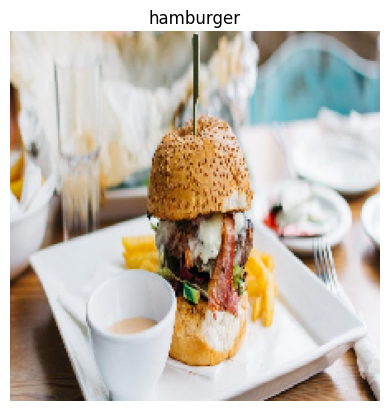

In [26]:
filename='food_test_images/burger_2.jpg'
img = load_img(filename, target_size=(224, 224))
img = img_to_array(img)
plt.imshow(img/255.)
pred = foodvision_model.predict(tf.expand_dims(img, 0), verbose=0)
plt.title(class_names[pred.argmax()])
plt.axis(False);

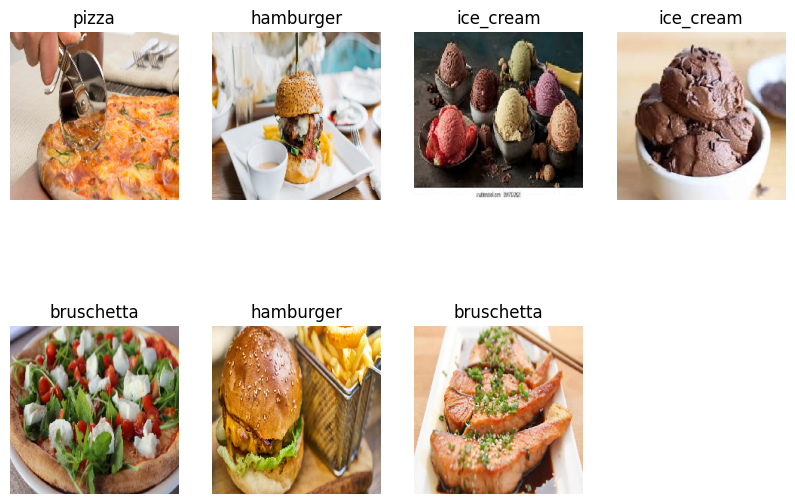

In [67]:
nrows = 2
ncols = 4

plt.figure(figsize=(10, 7))

for i, img in enumerate(test_images, start=1):
    plt.subplot(nrows, ncols, i)
    img = load_img(img, target_size=(224, 224))
    img = img_to_array(img)
    plt.imshow(img/255.)
    pred = foodvision_model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = pred.argmax()
    plt.title(class_names[pred_class])
    plt.axis(False);


two prediction are incorrect-
- the first image, yes - can be labelled as a wrong prediction
- second image actually looks like bruschetta


Looks like the model is fairly working well!!!

## PART 2 - Model Evaluations using different metrics

This is a classification task. We will use following classification evaluation techniques to evaluate our results:
- simplest method: accuracy score
- confusion matrix
- classification reports
- f1-score
- plot f1-score
- identify the most wrong predictions
 - visualize some of these wrong predictions
- roc_auc_score for multi-class
- top_k_accuracy_score
- visualize predictions

True labels from test dataset

In [32]:
## Getting true labels a from test dataset
y_true = []

for images, labels in test_dataset.unbatch():
    y_true.append(labels.numpy()) ## remember the labels were integers and not eonehot encoded

In [40]:
y_true = np.array(y_true) # convert to numpyarray

# view some labels
y_true[:5]

array([29, 81, 91, 53, 97])

Predicted labels

In [18]:
model = tf.keras.models.load_model('/content/food_vision_model_best_weights_ENetB0.keras')

In [19]:
model.evaluate(test_dataset)

790/790 [==============================] - 68s 70ms/step - loss: 0.9807 - accuracy: 0.7337


[0.9807271957397461, 0.7337425947189331]

In [21]:
# getting the prediction probabilities
pred_probs = model.predict(test_dataset)

790/790 [==============================] - 60s 71ms/step


In [22]:
## get the pred class from probabilities
y_pred = pred_probs.argmax(axis=1)
print(y_pred[:5])

[29 81 91 53 97]


In [23]:
y_pred = np.array(y_pred)

Save labels

In [37]:
# save the numpy array
# np.save('y_true', y_true)

In [25]:
# save the numpy array
# np.save('y_pred', y_pred)

Load labels

In [4]:
# load the saved numpy array
y_true = np.load('y_true.npy')

In [5]:
y_true[:5]

array([29, 81, 91, 53, 97])

In [6]:
# load saved y_pred array
y_pred = np.load('y_pred.npy')

In [7]:
y_pred[:5]

array([29, 81, 91, 53, 97])

Shape, dtype, and type of y_true and y_pred

In [28]:
y_true.shape, y_pred.shape

((25250,), (25250,))

In [29]:
y_true.dtype, y_pred.dtype

(dtype('int64'), dtype('int64'))

In [30]:
type(y_true), type(y_pred)

(numpy.ndarray, numpy.ndarray)

Load class_names

In [9]:
class_names = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']

### accuracy_score

In [8]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
acc

0.7337425742574257

### confusion_matrix

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

In [11]:
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

In [12]:
cm_norm

array([[0.444, 0.   , 0.096, ..., 0.02 , 0.004, 0.024],
       [0.   , 0.696, 0.   , ..., 0.   , 0.004, 0.   ],
       [0.028, 0.004, 0.804, ..., 0.004, 0.004, 0.   ],
       ...,
       [0.   , 0.   , 0.012, ..., 0.748, 0.   , 0.004],
       [0.004, 0.004, 0.   , ..., 0.   , 0.512, 0.   ],
       [0.016, 0.   , 0.   , ..., 0.004, 0.004, 0.76 ]])

In [13]:
## viewing as table
import pandas as pd

df = pd.DataFrame(cm, index=class_names, columns=class_names)
df

apple_pie  baby_back_ribs  baklava  beef_carpaccio  \
apple_pie             111               0       24               0   
baby_back_ribs          0             174        0               0   
baklava                 7               1      201               0   
beef_carpaccio          0               1        0             173   
beef_tartare            0               0        0               2   
...                   ...             ...      ...             ...   
tacos                   0               0        0               2   
takoyaki                0               0        1               1   
tiramisu                0               0        3               0   
tuna_tartare            1               1        0               2   
waffles                 4               0        0               0   

                beef_tartare  beet_salad  beignets  bibimbap  bread_pudding  \
apple_pie                  0           0         4         0             13   
baby_back_ribs             0           0         0         0              3   
baklava                    0           0         1         0              4   
beef_carpaccio             5           9         0         1              0   
beef_tartare             161           8         0         1              0   
...                      ...         ...       ...       ...            ...   
tacos                      0           0         0         0              0   
takoyaki                   2           0         3         1              0   
tiramisu                   0           1         1         0              2   
tuna_tartare              29           9         0         0              0   
waffles                    0           0         2         0              2   

                breakfast_burrito  ...  spaghetti_carbonara  spring_rolls  \
apple_pie                       1  ...                    0             0   
baby_back_ribs                  0  ...                    0             0   
baklava                         0  ...                    0             1   
beef_carpaccio                  0  ...                    0             0   
beef_tartare                    0  ...                    0             0   
...                           ...  ...                  ...           ...   
tacos                           8  ...                    0             1   
takoyaki                        0  ...                    0             0   
tiramisu                        0  ...                    0             0   
tuna_tartare                    0  ...                    0             0   
waffles                         0  ...                    0             0   

                steak  strawberry_shortcake  sushi  tacos  takoyaki  tiramisu  \
apple_pie           0                     3      1      1         3         5   
baby_back_ribs      9                     0      0      0         0         0   
baklava             1                     0      1      0         0         1   
beef_carpaccio      1                     2      0      0         0         0   
beef_tartare        0                     0      0      0         0         0   
...               ...                   ...    ...    ...       ...       ...   
tacos               0                     0      0    161         1         1   
takoyaki            0                     0      0      1       195         0   
tiramisu            1                     0      0      0         1       187   
tuna_tartare        0                     1      1      3         0         0   
waffles             0                     2      0      1         1         1   

                tuna_tartare  waffles  
apple_pie                  1        6  
baby_back_ribs             1        0  
baklava                    1        0  
beef_carpaccio             3        0  
beef_tartare              18        0  
...                      ...      ...  
tacos                      2        0  
takoyaki

To improve the confusion matrix view, we will plot it. We will view using sklearn function.

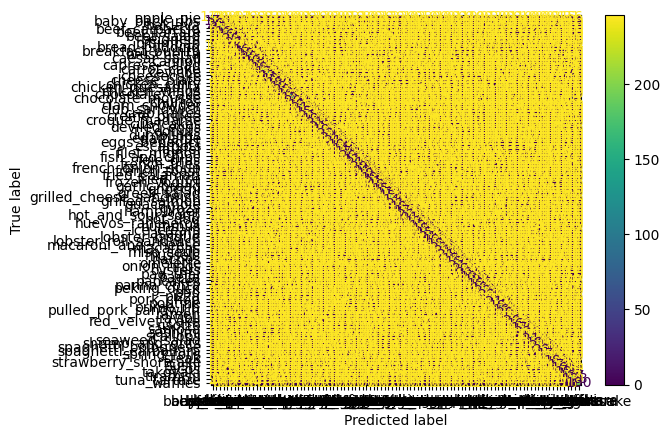

In [15]:
# ConfusionMatrixDisplay
display = ConfusionMatrixDisplay(cm, display_labels=class_names)
display.plot()
plt.show()

Oops!!. we will use custom function to improve the view further.

In [19]:
# Defining custom function to plot confusion matrix in a more nicer fashion

def plot_confusion_matrix(y_true, y_pred, class_names=None, norm=False, figsize=(16, 25), fontsize=None):
      # create cm
      cm = confusion_matrix(y_true, y_pred)
      cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      n_classes = cm.shape[0]

      # plotting
      fig, ax = plt.subplots(figsize=figsize)
      mat = ax.matshow(cm, cmap='Blues')
      fig.colorbar(mat)

      # look for class_names if provided use that else go with integer representation
      if class_names:
          labels=class_names
      else:
          labels=range(n_classes)

      # set the axes
      ax.set(xlabel='PREDICTED', ylabel='TRUE', title='Confusion Matrix: FoodVisionModel',
             xticks=range(n_classes), yticks=range(n_classes),
             xticklabels=labels, yticklabels=labels)

      # set the xaxis labels and ticks to bottom
      ax.xaxis.set_label_position('bottom')
      ax.xaxis.tick_bottom()

      # adjust the labels view
      plt.xticks(rotation=90, fontsize=14)
      plt.yticks(fontsize=14)

      # set threshold for colors
      threshold = (cm.max() + cm.min()) / 2.

      ## annotate the matrix display
      for i in range(cm.shape[0]):
          for j in range(cm.shape[0]):

              if norm:
                  plt.text(j, i, f"{cm[i, j]} ({cm_normalized[i, j]}*100:.1f%)",
                          ha='center',
                          color='white' if cm[i, j] > threshold else 'black',
                          size=fontsize)
              else:
                  plt.text(j, i, cm[i, j],
                          ha='center',
                          color='white' if cm[i, j] > threshold else 'black',
                          size=fontsize)





In [20]:
plot_confusion_matrix(y_true, y_pred, class_names=class_names, figsize=(100, 100), fontsize=20)

 Note, we can use seaborn as well

In [28]:
import seaborn as sns
sns.set(font_scale=3)
fig, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(cm, annot=True, ax=ax, annot_kws={"fontsize":20}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='True', title='Confusion_matrix',
       xticks=range(len(class_names)), yticks=range(len(class_names)),
       xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.show()

### classification report

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.44      0.50       250
           1       0.77      0.70      0.73       250
           2       0.71      0.80      0.75       250
           3       0.84      0.69      0.76       250
           4       0.55      0.64      0.59       250
           5       0.59      0.66      0.62       250
           6       0.79      0.83      0.81       250
           7       0.85      0.90      0.87       250
           8       0.61      0.44      0.51       250
           9       0.68      0.66      0.67       250
          10       0.59      0.64      0.61       250
          11       0.68      0.82      0.75       250
          12       0.76      0.78      0.77       250
          13       0.77      0.67      0.72       250
          14       0.78      0.74      0.76       250
          15       0.62      0.54      0.58       250
          16       0.60      0.55      0.57       250
          17       0.67    

Observations:
- outputs - precision, recall, f1-score, accuracy in single report

Lets export this report as dictionary and view in dataframe

In [31]:
cl_report = classification_report(y_true, y_pred, output_dict=True)

In [32]:
cl_report

{'0': {'precision': 0.5751295336787565,
  'recall': 0.444,
  'f1-score': 0.5011286681715575,
  'support': 250},
 '1': {'precision': 0.7733333333333333,
  'recall': 0.696,
  'f1-score': 0.7326315789473684,
  'support': 250},
 '2': {'precision': 0.7077464788732394,
  'recall': 0.804,
  'f1-score': 0.752808988764045,
  'support': 250},
 '3': {'precision': 0.8439024390243902,
  'recall': 0.692,
  'f1-score': 0.7604395604395604,
  'support': 250},
 '4': {'precision': 0.5494880546075085,
  'recall': 0.644,
  'f1-score': 0.5930018416206261,
  'support': 250},
 '5': {'precision': 0.5851063829787234,
  'recall': 0.66,
  'f1-score': 0.6203007518796992,
  'support': 250},
 '6': {'precision': 0.7931034482758621,
  'recall': 0.828,
  'f1-score': 0.8101761252446184,
  'support': 250},
 '7': {'precision': 0.8452830188679246,
  'recall': 0.896,
  'f1-score': 0.8699029126213592,
  'support': 250},
 '8': {'precision': 0.6098901098901099,
  'recall': 0.444,
  'f1-score': 0.513888888888889,
  'support': 2

In [34]:
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df.head()

precision  recall  f1-score  support
0   0.575130   0.444  0.501129    250.0
1   0.773333   0.696  0.732632    250.0
2   0.707746   0.804  0.752809    250.0
3   0.843902   0.692  0.760440    250.0
4   0.549488   0.644  0.593002    250.0

In [35]:
cl_report_df.tail()

precision    recall  f1-score       support
99             0.573991  0.512000  0.541226    250.000000
100            0.879630  0.760000  0.815451    250.000000
accuracy       0.733743  0.733743  0.733743      0.733743
macro avg      0.738466  0.733743  0.732858  25250.000000
weighted avg   0.738466  0.733743  0.732858  25250.000000

We don't want to last three rows...lets chop it off

In [37]:
cl_rep_df = cl_report_df[:101]
cl_rep_df.shape, cl_rep_df.tail()

((101, 4),
      precision  recall  f1-score  support
 96    0.602996   0.644  0.622824    250.0
 97    0.789474   0.780  0.784708    250.0
 98    0.558209   0.748  0.639316    250.0
 99    0.573991   0.512  0.541226    250.0
 100   0.879630   0.760  0.815451    250.0)

In [38]:
cl_rep_df.insert(loc=0,
                    column='class_names',
                    value=class_names)

In [39]:
# DataFrame with scores for each class
cl_rep_df

class_names  precision  recall  f1-score  support
0         apple_pie   0.575130   0.444  0.501129    250.0
1    baby_back_ribs   0.773333   0.696  0.732632    250.0
2           baklava   0.707746   0.804  0.752809    250.0
3    beef_carpaccio   0.843902   0.692  0.760440    250.0
4      beef_tartare   0.549488   0.644  0.593002    250.0
..              ...        ...     ...       ...      ...
96            tacos   0.602996   0.644  0.622824    250.0
97         takoyaki   0.789474   0.780  0.784708    250.0
98         tiramisu   0.558209   0.748  0.639316    250.0
99     tuna_tartare   0.573991   0.512  0.541226    250.0
100         waffles   0.879630   0.760  0.815451    250.0

[101 rows x 5 columns]

### f1-score

Since f1-score is combined score of precision and recall, we will focus towards f1 score.

Lets sort the dataframe by f1-score

In [42]:
# sorting descending order of f1-score
cl_rep_df = cl_rep_df.sort_values(by='f1-score', ascending=False)
cl_rep_df.head()

class_names  precision  recall  f1-score  support
33              edamame   0.980080   0.984  0.982036    250.0
63             macarons   0.932806   0.944  0.938370    250.0
91  spaghetti_carbonara   0.926829   0.912  0.919355    250.0
54    hot_and_sour_soup   0.928270   0.880  0.903491    250.0
75                  pho   0.896414   0.900  0.898204    250.0

Plotting the f1-score

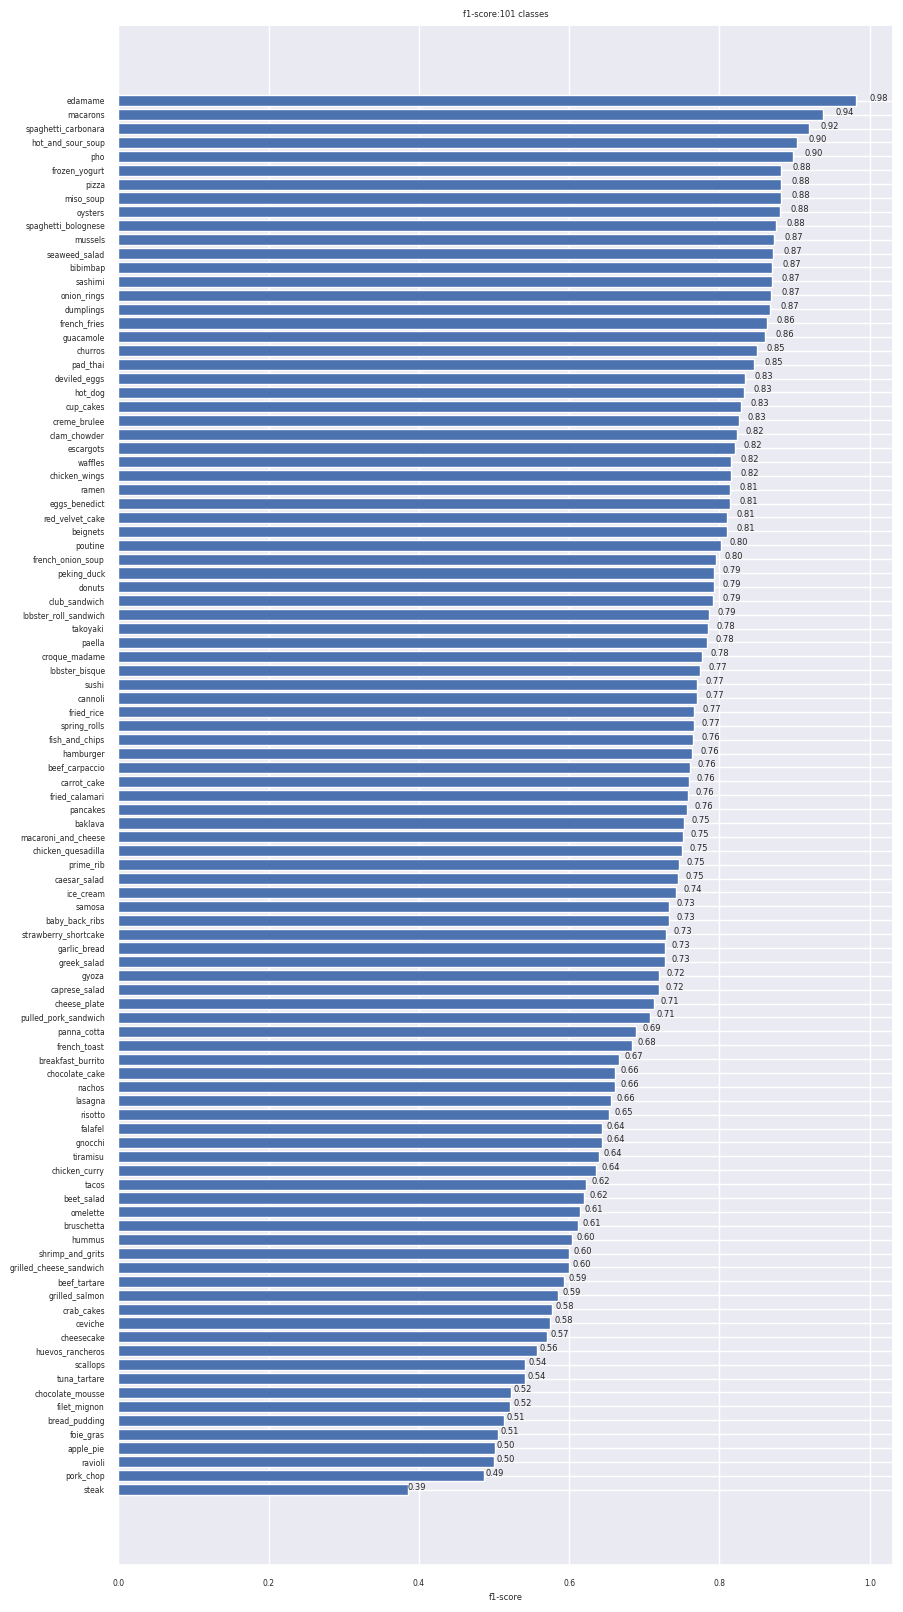

In [54]:
# code reference: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
sns.set(font_scale=0.5)
fig, ax = plt.subplots(figsize=(10, 20))
f1_rects = ax.barh(range(len(cl_rep_df)), cl_rep_df['f1-score'].values)
ax.set(xlabel='f1-score', title='f1-score:101 classes',
       yticks=range(len(cl_rep_df)), yticklabels=cl_rep_df['class_names'])
ax.invert_yaxis();
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
                f"{width:.2f}",
                ha='center', va='bottom')
autolabel(f1_rects)


Visualize 5 top performing classes

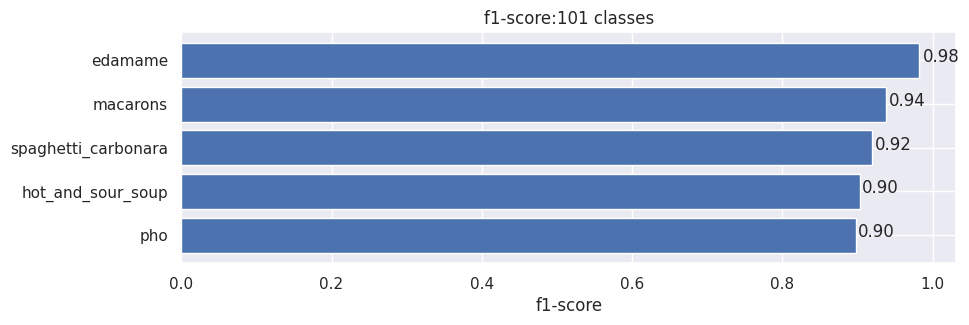

In [59]:
# code reference: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
# top 5
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 3))
f1_rects = ax.barh(range(len(cl_rep_df[:5])), cl_rep_df['f1-score'][:5].values)
ax.set(xlabel='f1-score', title='f1-score:101 classes',
       yticks=range(len(cl_rep_df[:5])), yticklabels=cl_rep_df['class_names'][:5])
ax.invert_yaxis();
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
                f"{width:.2f}",
                ha='center', va='bottom')
autolabel(f1_rects)


Visualize 5 worst performing classes

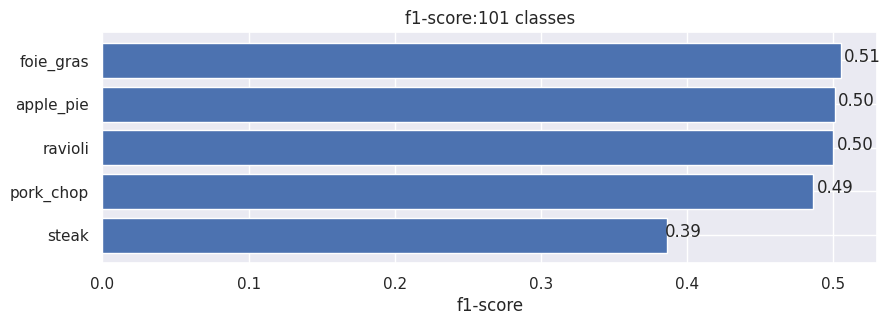

In [60]:
# code reference: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
# worst 5
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 3))
f1_rects = ax.barh(range(len(cl_rep_df[-5:])), cl_rep_df['f1-score'][-5:].values)
ax.set(xlabel='f1-score', title='f1-score:101 classes',
       yticks=range(len(cl_rep_df[-5:])), yticklabels=cl_rep_df['class_names'][-5:])
ax.invert_yaxis();
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
                f"{width:.2f}",
                ha='center', va='bottom')
autolabel(f1_rects)

Finding most worng prediction in test data

In [62]:
test_pred_df = pd.DataFrame({'y_true_label':[class_names[i] for i in y_true],
                                'y_pred_label':[class_names[i] for i in y_pred],
                                #'pred_probability':pred_probs.max(axis=1),
                                'y_true':y_true,
                                'y_pred':y_pred})

test_pred_df.head(10)

y_true_label          y_pred_label  y_true  y_pred
0            cup_cakes             cup_cakes      29      29
1                ramen                 ramen      81      81
2  spaghetti_carbonara   spaghetti_carbonara      91      91
3            hamburger             hamburger      53      53
4             takoyaki              takoyaki      97      97
5             takoyaki              takoyaki      97      97
6           bruschetta            bruschetta      10      10
7               donuts                donuts      31      31
8       beef_carpaccio        beef_carpaccio       3       3
9              waffles  strawberry_shortcake     100      94

Add an indicator tag 'is_correct'

In [63]:
test_pred_df['is_correct'] = test_pred_df['y_true'] == test_pred_df['y_pred']
test_pred_df.head()

y_true_label         y_pred_label  y_true  y_pred  is_correct
0            cup_cakes            cup_cakes      29      29        True
1                ramen                ramen      81      81        True
2  spaghetti_carbonara  spaghetti_carbonara      91      91        True
3            hamburger            hamburger      53      53        True
4             takoyaki             takoyaki      97      97        True

View the top 100 false predictions

In [65]:
test_pred_df[test_pred_df['is_correct']==False].sort_values(by='pred_probability', ascending=False)[:100]

y_true_label          y_pred_label  y_true  y_pred  \
7280                 pork_chop        baby_back_ribs      77       1   
19469            croque_madame  pulled_pork_sandwich      28      80   
7924              spring_rolls          tuna_tartare      92      99   
7922                  takoyaki            bruschetta      97      10   
19472                  mussels         seaweed_salad      65      88   
...                        ...                   ...     ...     ...   
7702   grilled_cheese_sandwich         eggs_benedict      49      34   
7722             seaweed_salad        chocolate_cake      88      21   
7703         french_onion_soup          creme_brulee      41      27   
7706        chicken_quesadilla               cannoli      19      12   
7710             chicken_curry          creme_brulee      18      27   

       is_correct  
7280        False  
19469       False  
7924        False  
7922        False  
19472       False  
...           ...  
7702        False  
7722        False  
7703        False  
7706        False  
7710        False  

[100 rows x 5 columns]

That's it

In [67]:
##End Note
print('The Lord is my Shepherd, i shall not lack. Psalms 23:1')

The Lord is my Shepherd, i shall not lack. Psalms 23:1
